In [4]:
import numpy as np
import subprocess
from mpl_toolkits import mplot3d
import ipympl
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tabulate import tabulate
from tqdm import tqdm

**Varying data size**

My dell g3 3779 host has 6 cores, 12 threads, 192K L1Dx6, 192K L1x6, 1.5M L2x6, 9M L3 (shared).

We are testing N^2 * double matrix.

MPI implementation splits it into submatrixes for separate processes. => nearly no overhead at calculation stage.
(Gathering time IS accounted due to we need the matrix for further operations)

OpenMP use shared memory => no overhead.
That means levels of LX-fit will be the same for all implementations.

Moreover, MPI implementation has an advantage in individual cache fitting. (It can effectively use i.e. 6x1.5M L2 for 9M matrix and 6 threads, as it is splitted on 6x1.5M)

Key sizes:
* ~160 -  full matrix L1 fit
* ~440 -  full matrix L2 fit
* ~1080 - full matrix L3 fit

If memory matters, we will see some breakings in log scale, not straight lines, But we dont't see them. Possible caule: sin() is libc function, quite hard to call and compute. Or program does more cpu burst than memory burst.

100%|██████████| 110/110 [00:25<00:00,  4.33it/s]


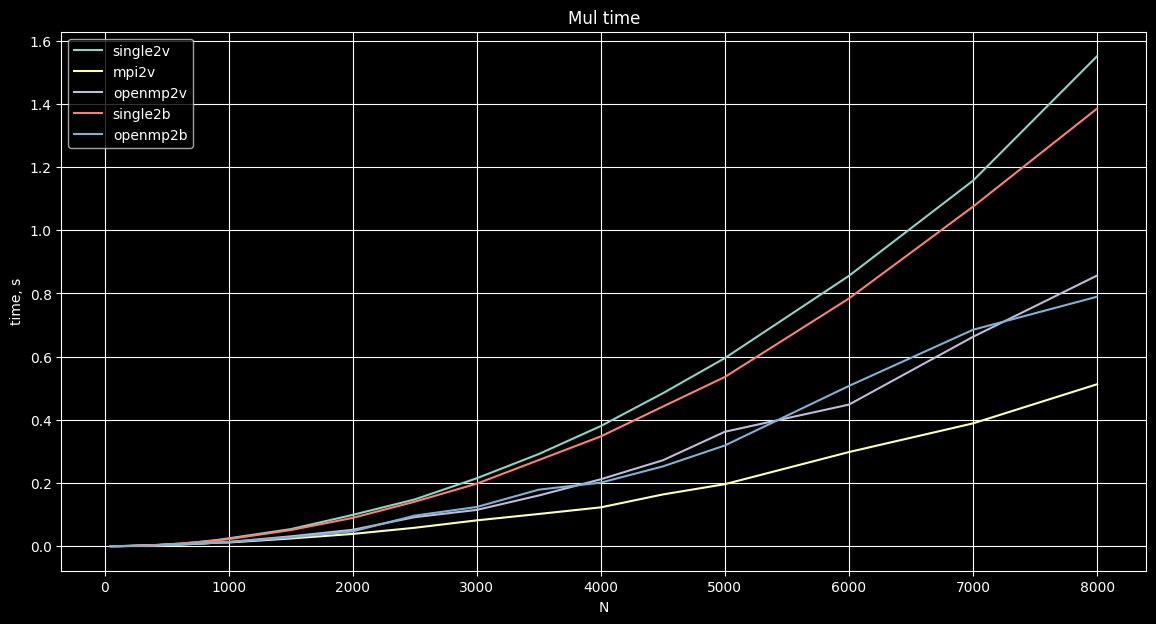

In [5]:
num_threads = 6 # CAUTION!!! N is 48 min

do_compare = False # enables result comparison with diff. Dramatically lowers the performance.
#do_compare = True

num_algos = 5
algos = []
algos.append ("single2v")
algos.append ("mpi2v")
algos.append ("openmp2v")
algos.append ("single2b")
algos.append ("openmp2b")
cmds = []
if do_compare:
    cmds.append ({"cmd": ["./tester_single2v", "{0}_res.txt".format (algos[0])], "threads_index": None, "reference_imp_index": None})
    cmds.append ({"cmd": ["mpirun", "--use-hwthread-cpus", "-np", "{0}".format (num_threads), "tester_mpi2v", "{0}_res.txt".format (algos[1])], "threads_index": 3, "reference_imp_index": 0})
    cmds.append ({"cmd": ["./tester_omp2v", "{0}".format (num_threads), "{0}_res.txt".format (algos[2])], "threads_index": 1, "reference_imp_index": 0})
    cmds.append ({"cmd": ["./tester_single2b", "{0}_res.txt".format (algos[3])], "threads_index": None, "reference_imp_index": None})
    cmds.append ({"cmd": ["./tester_omp2b", "{0}".format (num_threads), "{0}_res.txt".format (algos[4])], "threads_index": 1, "reference_imp_index": 3})
else:
    cmds.append ({"cmd": ["./tester_single2v"], "threads_index": None, "reference_imp_index": None})
    cmds.append ({"cmd": ["mpirun", "--use-hwthread-cpus", "-np", "{0}".format (num_threads), "tester_mpi2v"], "threads_index": 3, "reference_imp_index": 0})
    cmds.append ({"cmd": ["./tester_omp2v", "{0}".format (num_threads)], "threads_index": 1, "reference_imp_index": 0})
    cmds.append ({"cmd": ["./tester_single2b"], "threads_index": None, "reference_imp_index": None})
    cmds.append ({"cmd": ["./tester_omp2b", "{0}".format (num_threads)], "threads_index": 1, "reference_imp_index": 3})

Ns = np.array ((50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000, 7000, 8000))
num_points = Ns.shape[0]
times = np.zeros ((num_algos, num_points))

with tqdm(total=num_points * num_algos) as pbar:
    for i in range(0, num_points):
        for n_alg in range (0, num_algos):
            result = subprocess.run (cmds[n_alg]["cmd"] + ["{0}".format (Ns[i]), "{0}".format (Ns[i])], capture_output=True, text=True)
            res_split = result.stdout.split ()
            times[n_alg][i] = np.double (res_split[0])
            pbar.update (1)
        # compare results with single
        if do_compare:
            for n_alg in range (0, num_algos):
                if cmds[n_alg]["reference_imp_index"]:
                    diff = subprocess.run (["diff", "-q", "{0}_res.txt".format (algos[cmds[n_alg]["reference_imp_index"]]), "{0}_res.txt".format (algos[n_alg])])
                    assert diff.returncode == 0
    
plt.figure(figsize=(14, 7))
#plt.yscale('log')
#plt.xscale('log')
plt.grid ()
plt.title ("Mul time")
plt.xlabel ("N")
plt.ylabel ("time, s")
for i in range(0, num_algos):
    plt.plot (Ns, times[i], 'C{0}'.format (i), label = algos[i])
plt.legend ()

And in log scale

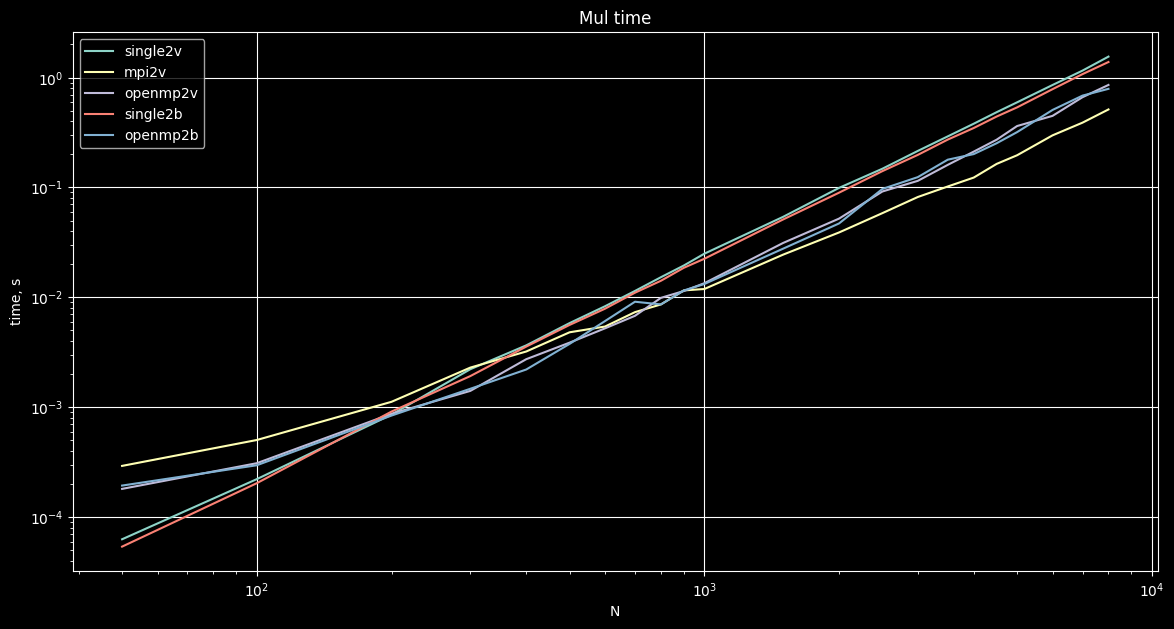

In [6]:
plt.figure(figsize=(14, 7))
plt.yscale('log')
plt.xscale('log')
plt.grid ()
plt.title ("Mul time")
plt.xlabel ("N")
plt.ylabel ("time, s")
for i in range(0, num_algos):
    plt.plot (Ns, times[i], 'C{0}'.format (i), label = algos[i])
plt.legend ()

100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


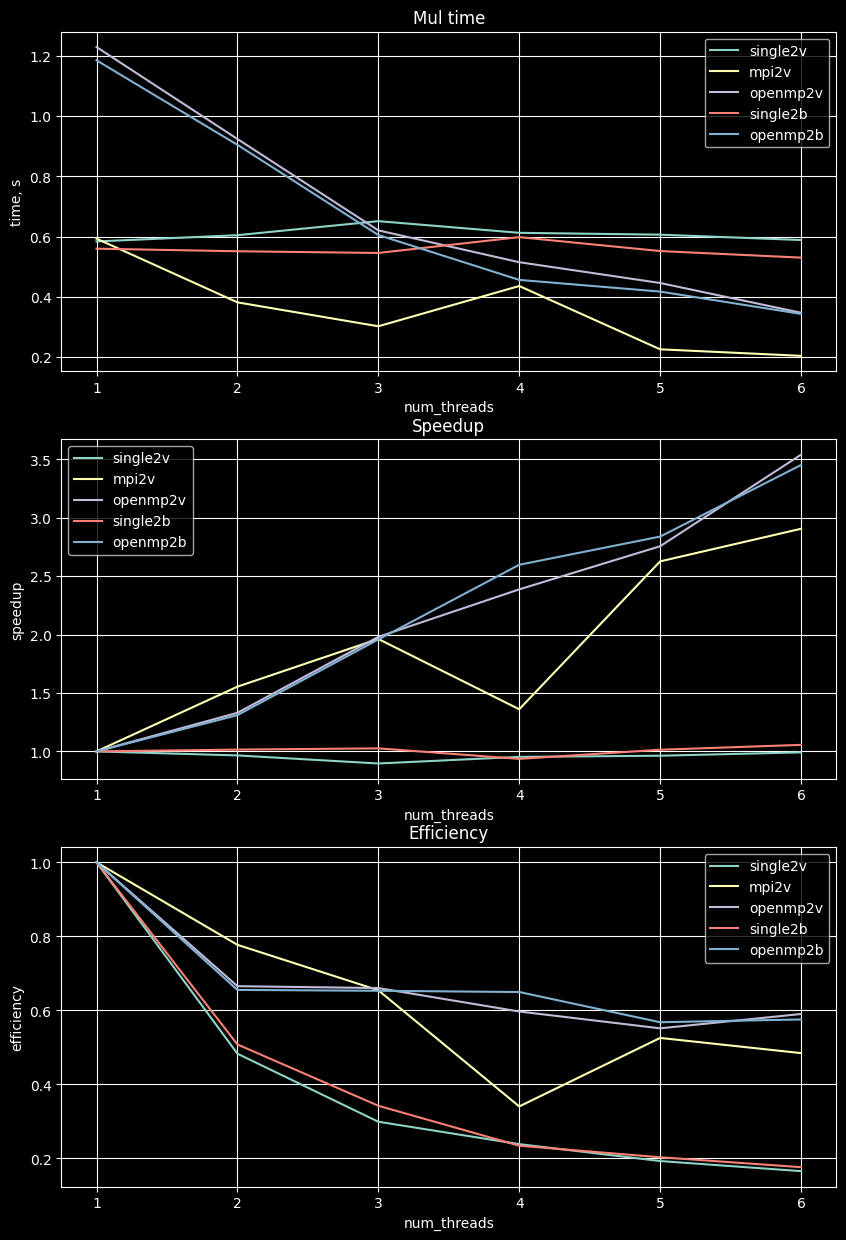

In [7]:
N = 5000
N_THR = 6
num_threads = np.arange (1, N_THR + 1, 1)
times = np.zeros ((num_algos, num_threads.shape[0]))

with tqdm(total=N_THR * num_algos) as pbar:
    for i in range(0, num_threads.shape[0]):
        for n_alg in range (0, num_algos):
            if cmds[n_alg]["threads_index"]:
                cmds[n_alg]["cmd"][cmds[n_alg]["threads_index"]] = "{0}".format(i + 1)
            result = subprocess.run (cmds[n_alg]["cmd"] + ["{0}".format (N), "{0}".format (N)], capture_output=True, text=True)
            res_split = result.stdout.split ()
            times[n_alg][i] = np.double (res_split[0])
            pbar.update (1)
        # compare results with single
        if do_compare:
            for n_alg in range (1, num_algos):
                diff = subprocess.run (["diff", "-q", "{0}_res.txt".format (algos[0]), "{0}_res.txt".format (algos[n_alg])])
                assert diff.returncode == 0

plt.figure(figsize=(10, 15))

plt.subplot (311)
plt.grid ()
plt.title ("Mul time")
plt.xlabel ("num_threads")
plt.ylabel ("time, s")
for i in range(0, num_algos):
    plt.plot (num_threads, times[i], 'C{0}'.format (i), label = algos[i])
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Speedup")
plt.xlabel ("num_threads")
plt.ylabel ("speedup")
for i in range(0, num_algos):
    plt.plot (num_threads, times[i][0] / times[i], 'C{0}'.format (i), label = algos[i])
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Efficiency")
plt.xlabel ("num_threads")
plt.ylabel ("efficiency")
for i in range(0, num_algos):
    plt.plot (num_threads, times[i][0] / times[i] / num_threads, 'C{0}'.format (i), label = algos[i])
plt.legend ()